In [1]:
from IPython.display import display,clear_output,HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline

import json, hmac, hashlib, time, requests, base64
from requests.auth import AuthBase
from multiprocessing import Pool
import traceback
import sys
import csv
import os

from win10toast import ToastNotifier

#%run logging.ipynb

In [3]:
arb_algo_path = os.getcwd().strip("python_scripts")
print(arb_algo_path)
downloads_path = os.getcwd().strip("Dropbox\\Bitcoin\\ArbAlgo\\python_scripts")+"\\Downloads\\"
downloads_path

C:\Users\Jameshuckle\Dropbox\Bitcoin\ArbAlgo\


'C:\\Users\\Jameshuckle\\Downloads\\'

In [4]:
from deribit_api import RestClient

In [5]:
env = "spread"
####################

if env == "demo":
    url = "https://test.deribit.com"
    key = "9z4u9P2WLr62"
    secret = "VZ7X2WD7O6NYXQUV7YCWQDDGI2BG4BKZ"
    
elif env == "spread":
    url = "https://www.deribit.com"
    key = "5WmL4PVQDkYsr"
    secret = "SCUMOH5HNLQ6DBVD7LYJJQDIGHRSHWQO"

client = RestClient(key, secret, url)

#client.account()

In [6]:
def generate_signature(key,secret, action, data):
    tstamp = int(time.time()* 1000)
    signature_data = {
        '_': tstamp,
        '_ackey': key,
        '_acsec': secret,
        '_action': action
    }
    signature_data.update(data)
    sorted_signature_data = OrderedDict(sorted(signature_data.items(), key=lambda t: t[0]))
    
    def converter(data):
        key = data[0]
        value = data[1]
        if isinstance(value, list):
            return '='.join([str(key), ''.join(value)])
        else:
            return '='.join([str(key), str(value)])
        
    items = map(converter, sorted_signature_data.items())
    signature_string = '&'.join(items)
    sha256 = hashlib.sha256()
    sha256.update(signature_string.encode("utf-8"))
    sig = self.key + "." + str(tstamp) + "." 
    sig += base64.b64encode(sha256.digest()).decode("utf-8")
    return sig

#generate_signature(key,secret, action, data)

In [7]:
from dateutil.relativedelta import relativedelta, FR

def contract_sym(date,roll_buffer=0): ## roll_buffer is how many hours you want to switch to the seconds contract before it really expires
    expiry = [datetime.datetime(date.year,3,1,8,0)+relativedelta(day=32)+relativedelta(weekday=FR(-1)),
              datetime.datetime(date.year,6,1,8,0)+relativedelta(day=32)+relativedelta(weekday=FR(-1)),
              datetime.datetime(date.year,9,1,8,0)+relativedelta(day=32)+relativedelta(weekday=FR(-1)),
              datetime.datetime(date.year,12,1,8,0)+relativedelta(day=32)+relativedelta(weekday=FR(-1)),
              datetime.datetime(date.year+1,3,1,8,0)+relativedelta(day=32)+relativedelta(weekday=FR(-1)),
              datetime.datetime(date.year+1,6,1,8,0)+relativedelta(day=32)+relativedelta(weekday=FR(-1))]    
    
    contracts = [[expiry[0]-datetime.timedelta(hours=roll_buffer),"BTC-"+expiry[0].date().strftime("%d%b").upper()],
                 [expiry[1]-datetime.timedelta(hours=roll_buffer),"BTC-"+expiry[1].date().strftime("%d%b").upper()],
                 [expiry[2]-datetime.timedelta(hours=roll_buffer),"BTC-"+expiry[2].date().strftime("%d%b").upper()],
                 [expiry[3]-datetime.timedelta(hours=roll_buffer),"BTC-"+expiry[3].date().strftime("%d%b").upper()],
                 [expiry[4]-datetime.timedelta(hours=roll_buffer),"BTC-"+expiry[4].date().strftime("%d%b").upper()],
                 [expiry[5]-datetime.timedelta(hours=roll_buffer),"BTC-"+expiry[5].date().strftime("%d%b").upper()]]
    
    for x in range(len(contracts)):
        if date < contracts[x][0]:
            front_sym = contracts[x][1] + str(contracts[x][0].year)[2:4]
            second_sym = contracts[x+1][1] + str(contracts[x+1][0].year)[2:4]
            break
        else:
            continue
            
    return front_sym,second_sym

date = datetime.datetime.utcnow()
fut_sym, back_sym = contract_sym(date,roll_buffer=3)
(fut_sym, back_sym)

('BTC-28JUN19', 'BTC-27SEP19')

## yesterday's data and todays

In [8]:
### DERIBIT DATA ######
def get_single_data(instrument,start,end): # "perpetual", "front_quarter", "back_quarter"
    
    master = pd.DataFrame()
    date = start
    while date <= end:
        try:
            try:
                data = pd.read_csv(arb_algo_path+"data\deri_data\\"+str(date)+"_btc_"+instrument+"_quote"+".csv")
            except FileNotFoundError:
                data = pd.read_csv(arb_algo_path+"data\deri_data\\"+str(date)+"_btc_"+instrument+"_quote"+".zip")
            ### take only the level 1 data, and filter it for any non-movement ###
            data = data[data["level"] == 1]
            data[["bid_price_dup","bid_size_dup","ask_price_dup","ask_size_dup"]] = data[["bid_price","bid_size","ask_price","ask_size"]].diff(1)
            dups = data[["bid_price_dup","bid_size_dup","ask_price_dup","ask_size_dup"]].abs().sum(axis="columns") == 0
            dups = dups[dups]
            data = data.drop(dups.index,axis="rows")
            data = data.drop(["bid_price_dup","bid_size_dup","ask_price_dup","ask_size_dup"],axis="columns")
            data = data.reset_index(drop=True)
            master = pd.concat([master,data],sort=True)
            print(date,instrument)
            clear_output(wait=True)
            date = date+datetime.timedelta(days=1)
        except FileNotFoundError:           
            print(date,"not found",instrument)
            date = date+datetime.timedelta(days=1)
    master = master.drop(["my_utc_time","level"],axis="columns")
    return master

#start = datetime.datetime(2019,2,1).date() #(2018,9,21) earliest
#end = start+datetime.timedelta(days=1)
#
#perp = get_single_data("perpetual",start,end)
##display(perp.head())
#fut = get_single_data("front_quarter",start,end)
##display(fut.head())
#master = perp.merge(fut,on="timestamp",how="outer",sort=True)
#master = master.ffill()
#master = master.dropna(axis="rows")
#master.head()

In [9]:
### DERIBIT DATA ######
def deri_hist_data(start,end,mov,mar,f,manual_mid,data_source):
    #start = datetime.datetime(2018,10,14).date() #(2018,9,21) earliest
    #end = datetime.datetime.now().date()
    #end = datetime.datetime(2018,10,13).date()
    #################################################
    
    if data_source == "duel":
        ##### old perp fut method ###
        date = start
        master = pd.DataFrame()
        while date <= end:
            try:
                data = pd.read_csv(arb_algo_path+"\data\deri_data\\"+str(date)+"_perp_fut"+".csv")
            except:
                data = pd.read_csv(arb_algo_path+"\data\deri_data\\"+str(date)+"_perp_fut"+".zip")
            master = pd.concat([master,data],sort=True)
            date = date+datetime.timedelta(days=1)
        #########################
    elif data_source == "single":
        ###### new single data (slower) method ###
        perp = get_single_data("perpetual",start,end)
        #display(perp.head())
        fut = get_single_data("front_quarter",start,end)
        #display(fut.head())
        master = perp.merge(fut,on="timestamp",how="outer",sort=True)
        master = master.ffill()
        master = master.dropna(axis="rows")
      
    # remove duplicates of bid ask prices (no real movement)
    master[["bid_price_x","ask_price_x","bid_price_y","ask_price_y"]] = master[["bid_price_x","ask_price_x","bid_price_y","ask_price_y"]].astype(float)
    price_cols = ["bid_price_x","ask_price_x","bid_price_y","ask_price_y"]
    shift_col_names = [x+"_shift" for x in price_cols]
    dup_col_names = [x+"_dup" for x in price_cols]
    
    master[shift_col_names] = master[price_cols].shift(1)
    
    print("size before dup drop",len(master))
    for col in price_cols:
        master[col+"_dup"] = master[col] - master[col+"_shift"]
    master["dups"] = master[dup_col_names].sum(axis=1)
    master = master[master["dups"] != 0]
    master.drop(["dups"]+shift_col_names+dup_col_names,axis=1,inplace=True) 
    print("size after dup drop",len(master))
    
    #### new individual from full ws ###
    ##perp = get_single_data("perpetual")
    ##fut = get_single_data("front_quarter")
    ###display(perp.head())
    ###display(fut.head())
    ##master = perp.merge(fut,on="my_utc_time",how="outer",sort=True)
    ##master = master.ffill()
    ##master = master.dropna(axis="rows")
    ##
    ##master["timestamp"] = pd.to_datetime(master["my_utc_time"])
    
    ## change column names to suit backtester
    master.rename({'bid_price_x': 'bidPrice_x',
                   'ask_price_x': 'askPrice_x',
                   'bid_size_x': 'bidSize_x',
                   'ask_size_x': 'askSize_x',
                   'bid_price_y': 'bidPrice_y',
                   'ask_price_y': 'askPrice_y',
                   'bid_size_y': 'bidSize_y',
                   'ask_size_y': 'askSize_y',
                   'instrument_x': 'symbol_x',
                   'instrument_y': 'symbol_y'},inplace=True,axis=1)
    master.drop("my_utc_time",axis=1,inplace=True) if data_source == "duel" else None
    master = master.sort_values("timestamp")
    master = master.reset_index(drop=True)
    master["sell_perp"] = master["bidPrice_x"] - master["askPrice_y"]
    master["buy_perp"] = master["askPrice_x"] - master["bidPrice_y"]
    master["timestamp"] = pd.to_datetime(master["timestamp"])    
    #display(master.head())
    
    #### variables ####
    mov_avg = mov #80       
    margin = mar #0.09/100 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    ## OR if using bollinger band ##
    std_devs = 2.5 #2.5 roughly equivilent to 0.075 margin
    
    ##### variables ##########################
    slippage = 0.5
    band_type = "band" #"boll" , "band"
    ##########################################
    ### fees #########
    taker = 0.075/100 #
    maker = -0.02/100
    fee = f#(taker+maker)
    ###################################
    
    com_data2 = master
    bar_data = com_data2.set_index("timestamp",drop=True).copy()
    
    price_mid_avg = pd.Series(bar_data[["askPrice_x","bidPrice_x","askPrice_y","bidPrice_y"]].resample('1Min').last().ffill().mean(axis=1),name="price_mid_avg")
    perp_buy_avg = pd.Series(bar_data['buy_perp'].resample('1Min').last().ffill(),name = "perp_buy_avg")
    perp_sell_avg = pd.Series(bar_data['sell_perp'].resample('1Min').last().ffill(),name = "perp_sell_avg")
    
    ### combine 1min sampled data from buy and sell
    bar_data = pd.concat([perp_buy_avg, perp_sell_avg,price_mid_avg], axis=1)
    ## create spread mid avg and roll it
    bar_data["spread_mid_avg"] = (bar_data["perp_buy_avg"]+bar_data["perp_sell_avg"])/2
    bar_data["spread_mid_avg_rolling"] = bar_data["spread_mid_avg"].rolling(window=mov_avg, min_periods=mov_avg).mean()
    bar_data["spread_mid_avg_rolling"] = bar_data["spread_mid_avg_rolling"].shift(1)
    #print(bar_data["spread_mid_avg_rolling"][-10:])
    bar_data["mov_avg_speed"] = (bar_data["spread_mid_avg_rolling"].diff())*mov_avg/((margin+fee*2)*price_mid_avg)
    
    ## stddev / band movement
    bar_data["spread_mid_avg_rolling_std"] = bar_data["spread_mid_avg"].rolling(window=mov_avg, min_periods=mov_avg).std()/bar_data["mov_avg_speed"].abs()
    bar_data["spread_mid_avg_rolling_std"] = bar_data["spread_mid_avg_rolling_std"].rolling(window=200, min_periods=50).mean()
    bar_data["spread_mid_avg_rolling_std"] = bar_data["spread_mid_avg_rolling_std"].shift(1)
    ## create % time above or below rolling average
    beyond_mov_avg = 60
    def filter_movement(row):
        try:
            if row["perp_sell_avg"] > row["spread_mid_avg_rolling"]:
                return 1
            if row["perp_buy_avg"] < row["spread_mid_avg_rolling"]:
                return -1
            return 0
        except:
            print("nope")
            return np.nan
    bar_data["beyond_mid_avg_rolling"] = bar_data.apply(filter_movement,axis=1)
    #print(list(bar_data["beyond_mid_avg_rolling"][-beyond_mov_avg:].values))
    bar_data["%_beyond_mid_avg_rolling"] = bar_data["beyond_mid_avg_rolling"].rolling(window=beyond_mov_avg,min_periods=beyond_mov_avg).mean()
    
    ## interestingly now combine the 1min data with the original tick data #####
    cols = ["spread_mid_avg_rolling_std","spread_mid_avg_rolling","price_mid_avg","spread_mid_avg","mov_avg_speed","%_beyond_mid_avg_rolling"]
    com_data2 = com_data2.merge(bar_data[cols],how="outer",on="timestamp",sort=True)
    com_data2 = com_data2.sort_values("timestamp")
    ## Leaving the rolling average to permeate forward, we have alreadly shifted it forward one bar in the previous function to account for look ahead bias
    com_data2[cols] = com_data2[cols].ffill()
    ## drop the now dummy rows from the 1min data, as they are no longer helpful
    com_data2 = com_data2.dropna(axis=0,subset=["symbol_x"])
    ## just roll it forward one tick this time, as the close of the previous 1m bar will not be known until the open of the next bar, or just the next tick really
    com_data2["spread_mid_avg_rolling"] = com_data2["spread_mid_avg_rolling"].shift(1)
    band_size = ((com_data2["price_mid_avg"]*fee)+(com_data2["price_mid_avg"]*margin))
    
    if manual_mid[0] == True:
        com_data2["sell_perp_band"] = manual_mid[1]
        com_data2["buy_perp_band"] = manual_mid[2]  
    else:
        com_data2["sell_perp_band"] = com_data2["spread_mid_avg_rolling"] + band_size
        com_data2["sell_perp_band"] = (com_data2["sell_perp_band"]*2).round()/2
        com_data2["buy_perp_band"] = com_data2["spread_mid_avg_rolling"] - band_size
        com_data2["buy_perp_band"] = (com_data2["buy_perp_band"]*2).round()/2
        
        sell_perp_std = com_data2["sell_perp"].rolling(window=mov_avg, min_periods=mov_avg).std()
        buy_perp_std = com_data2["buy_perp"].rolling(window=mov_avg, min_periods=mov_avg).std()
        
        com_data2["sell_perp_boll"] = com_data2["spread_mid_avg_rolling"]+sell_perp_std*std_devs
        com_data2["sell_perp_boll"] = (com_data2["sell_perp_boll"]*2).round()/2
        com_data2["buy_perp_boll"] = com_data2["spread_mid_avg_rolling"]-buy_perp_std*std_devs
        com_data2["buy_perp_boll"] = (com_data2["buy_perp_boll"]*2).round()/2
    
    com_data2 = com_data2[1:]
    
    del bar_data
    return com_data2

#mov_avg = 80
#margin = 0.09/100
#taker = np.mean([0.05,0.075])/100
#maker = np.mean([-0.025,-0.02])/100
#fees = (taker+maker)
#manual_midpoint = [False,0,50]  # True, sell price, buy_price
#start = datetime.datetime.now()-datetime.timedelta(days=2)
#end = datetime.datetime.now()-datetime.timedelta(days=1)
#master = deri_hist_data(start.date(),end.date(),mov_avg,margin,fees,manual_midpoint,data_source="duel")
#master.tail()

## trade history

In [10]:
def trade_history(date):
    data = pd.DataFrame(client.tradehistory(1000,"all"))
    data["timeStamp"] = pd.to_datetime(data["timeStamp"],unit="ms")
    last_trade = data["tradeId"].values[-1]
    if pd.to_datetime(data["timeStamp"].values[-1]) > date:
        try:
            while True:
                additional = pd.DataFrame(client.tradehistory(1000,"all",last_trade))
                additional["timeStamp"] = pd.to_datetime(additional["timeStamp"],unit="ms")
                display(last_trade,additional.tail(1))
                data = data.append(additional)
                last_trade = data["tradeId"].values[-1]
                if pd.to_datetime(data["timeStamp"].values[-1]) <= date:
                    break
        except:
            print("cannot access enough data on server to satisfy requirment")
        data = data.reset_index(drop=True)
        return data

#date = datetime.datetime(2018,12,1)
#trade_history(date)

2019-05-05 16:16:48.471200 2019-05-15 16:16:48.471200
(903, 7)
finished
avg perp buy price 7546.06 avg perp sell price 7566.43 total avg profit perp trades 20.37
avg fut buy price 7601.02 avg fut sell price 7572.11 total avg profit fut trades -28.91
avg_buy_spread: -26.06 avg_sell_spread: -34.59
avg gross profit per round trip($): -8.53 @ 1 BTC
avg fees per RT($): 6.05 @ 1 BTC
avg funding per RT($): 0.71 @ 1 BTC
net profit per RT($): -15.29 @ 1 BTC
total round trips: 162.0
total days: 9.5
expected total profit($): -2476.98 @ 1 BTC
expected total profit(B): -0.32716682 @ 1 BTC
forecast yearly profit($) at 3BTC: -285504
yearly return on capital (x's): -53.9
monthly % return: -449
compounded_yearly_return: 17304394590

# not paired trades 321


,timeStamp,fee,price,quantity,instrument,side,orderId
902,2019-05-12 04:26:22.315,3.132400e-04,7182.378000,500,BTC-28JUN19,close sell,11788380093.0
901,2019-05-12 04:26:22.321,-1.560400e-04,7209.750000,500,BTC-PERPETUAL,close buy,11787628100.0
894,2019-05-12 06:32:45.587,4.564000e-05,7394.500000,50,BTC-PERPETUAL,open sell,11791485511.0
891,2019-05-12 06:32:46.837,-4.454000e-05,7356.250000,182,BTC-28JUN19,open buy,11791485323.0
890,2019-05-12 06:32:46.906,1.205000e-04,7394.500000,132,BTC-PERPETUAL,open sell,11791486593.0
889,2019-05-12 08:00:00.154,0.000000e+00,7498.030000,10848,BTC-28JUN19,long,nan
880,2019-05-12 08:12:51.080,-1.239000e-04,7263.750000,500,BTC-28JUN19,open buy,11794677177.0
879,2019-05-12 08:12:51.504,3.096700e-04,7265.750000,500,BTC-28JUN19,close sell,11794677570.0
876,2019-05-12 08:12:58.974,-9.928000e-05,7252.083333,400,BTC-28JUN19,open buy,11794682116.0
875,2019-05-12 08:12:59.063,1.848700e-04,7302.250000,200,BTC-PERPETUAL,open sell,11794682510.0


'combined trades'

,fee_x,fee_y,instrument_x,instrument_y,orderId_x,orderId_y,price_x,price_y,quantity_x,quantity_y,side_x,side_y,timeStamp_x,timeStamp_y,spread_price,latency,plot_open_buy,plot_open_sell,plot_close_buy,plot_close_sell
290,-4.736000e-05,9.520000e-05,BTC-PERPETUAL,BTC-28JUN19,11788986396.0,11789699348.0,7268.250000,7232.000000,153,153,open sell,open buy,2019-05-12 05:29:10.130,2019-05-12 05:29:10.228,36.250000,00:00:00.098000,NaN,36.250000,NaN,NaN
289,-1.518700e-04,3.053800e-04,BTC-PERPETUAL,BTC-28JUN19,11790489833.0,11791465429.0,7407.750000,7367.919000,500,500,open sell,open buy,2019-05-12 06:32:08.305,2019-05-12 06:32:08.359,39.831000,00:00:00.054000,NaN,39.831000,NaN,NaN
288,-1.524000e-04,3.057300e-04,BTC-PERPETUAL,BTC-28JUN19,11790489825.0,11791484904.0,7382.000000,7359.450000,500,500,close buy,close sell,2019-05-12 06:32:44.381,2019-05-12 06:32:44.407,22.550000,00:00:00.026000,NaN,NaN,22.550000,NaN
287,2.902800e-04,-7.781000e-05,BTC-PERPETUAL,BTC-28JUN19,11791485854.0,11791485323.0,7394.500000,7356.250000,318,318,open sell,open buy,2019-05-12 06:32:45.928,2019-05-12 06:32:45.850,38.250000,00:00:00.078000,NaN,38.250000,NaN,NaN
286,-1.524700e-04,3.063800e-04,BTC-PERPETUAL,BTC-28JUN19,11794652164.0,11794656441.0,7378.750000,7343.837000,500,500,close buy,close sell,2019-05-12 08:12:22.798,2019-05-12 08:12:23.039,34.913000,00:00:00.241000,NaN,NaN,34.913000,NaN
285,-1.522200e-04,3.070300e-04,BTC-PERPETUAL,BTC-28JUN19,11794656813.0,11794658871.0,7390.500000,7328.200000,500,500,open sell,open buy,2019-05-12 08:12:25.857,2019-05-12 08:12:25.952,62.300000,00:00:00.095000,NaN,62.300000,NaN,NaN
284,-9.489000e-05,1.908000e-04,BTC-PERPETUAL,BTC-28JUN19,11794659887.0,11794664646.0,7327.000000,7287.750000,309,309,close buy,close sell,2019-05-12 08:12:33.719,2019-05-12 08:12:33.852,39.250000,00:00:00.133000,NaN,NaN,39.250000,NaN
283,-5.887000e-05,1.183200e-04,BTC-PERPETUAL,BTC-28JUN19,11794659887.0,11794676874.0,7300.500000,7264.146597,191,191,close buy,close sell,2019-05-12 08:12:50.269,2019-05-12 08:12:50.528,36.353403,00:00:00.259000,NaN,NaN,36.353403,NaN
282,-1.540800e-04,3.101300e-04,BTC-PERPETUAL,BTC-28JUN19,11794677945.0,11794681715.0,7301.500000,7255.177000,500,500,close buy,close sell,2019-05-12 08:12:57.495,2019-05-12 08:12:58.059,46.323000,00:00:00.564000,NaN,NaN,46.323000,NaN
281,-1.543400e-04,3.102100e-04,BTC-PERPETUAL,BTC-28JUN19,11794686717.0,11794687319.0,7289.000000,7253.195500,500,500,close buy,close sell,2019-05-12 08:13:05.792,2019-05-12 08:13:06.788,35.804500,00:00:00.996000,NaN,NaN,35.804500,NaN


size before dup drop 3424453
size after dup drop 897335


'hist data + combined trades'

,askPrice_x,askPrice_y,askSize_x,askSize_y,bidPrice_x,bidPrice_y,bidSize_x,bidSize_y,symbol_x,symbol_y,timestamp,sell_perp,buy_perp,spread_mid_avg_rolling_std,spread_mid_avg_rolling,price_mid_avg,spread_mid_avg,mov_avg_speed,%_beyond_mid_avg_rolling,sell_perp_band,buy_perp_band,sell_perp_boll,buy_perp_boll,fee_x,fee_y,instrument_x,instrument_y,orderId_x,orderId_y,price_x,price_y,quantity_x,quantity_y,side_x,side_y,timeStamp_x,timeStamp_y,spread_price,latency,plot_open_buy,plot_open_sell,plot_close_buy,plot_close_sell
897619,7980.25,8013.25,2213.0,100.0,7980.0,8007.00,1597.0,637.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-15 15:16:58.490,-33.25,-26.75,31.536612,-36.3425,7994.375,-28.5,0.461634,0.9,-23.0,-50.0,-31.0,-40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN
897620,7980.25,8012.75,2213.0,100.0,7980.0,8005.75,1597.0,574.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-15 15:16:58.657,-32.75,-25.50,31.536612,-36.3425,7994.375,-28.5,0.461634,0.9,-23.0,-50.0,-31.0,-40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN
897621,7980.25,8012.25,812.0,100.0,7980.0,8005.75,2395.0,614.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-15 15:16:58.912,-32.25,-25.50,31.536612,-36.3425,7994.375,-28.5,0.461634,0.9,-23.0,-50.0,-31.0,-40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN
897622,7980.25,8011.75,4593.0,100.0,7980.0,8005.75,2395.0,614.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-15 15:16:59.120,-31.75,-25.50,31.536612,-36.3425,7994.375,-28.5,0.461634,0.9,-23.0,-50.0,-31.0,-40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN
897623,7980.25,8011.50,4595.0,200.0,7980.0,8005.75,2395.0,614.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-15 15:16:59.328,-31.50,-25.50,31.536612,-36.3425,7994.375,-28.5,0.461634,0.9,-23.0,-50.0,-31.0,-40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN


'profit data'

,Id,Instrument,Type,Side,Quantity,Price,Cash flow,Funding,Fee paid,Change,Balance,Transaction Id,Order Id,Info,timestamp,balance_diff,funding_avg,trade_profit,running_profit,usdrunning_profit,btcrunning_profit
1830,42635775.0,BTC-28JUN19,trade,close buy,10.0,8242.00,-0.000574,NaN,0.000005,-0.000005,0.242797,20452470.0,11870985071.0,Source: api,2019-05-14 07:39:56.601,-0.000005,9.233370e-08,-0.000580,-0.049533,-408.252376,-0.049533
1831,42635776.0,BTC-28JUN19,trade,close buy,97.0,8244.75,-0.005611,NaN,0.000053,-0.000053,0.242744,20452471.0,11870985071.0,Source: api,2019-05-14 07:39:56.601,-0.000053,9.233370e-08,-0.005663,-0.055197,-455.082632,-0.055197
1832,42635777.0,BTC-28JUN19,trade,close buy,23.0,8246.75,-0.001337,NaN,0.000013,-0.000013,0.242732,20452472.0,11870985071.0,Source: api,2019-05-14 07:39:56.601,-0.000013,9.233370e-08,-0.001350,-0.056546,-466.322655,-0.056546
1833,42652318.0,BTC-PERPETUAL,settlement,long,320.0,8345.24,NaN,-0.00794,NaN,-0.149378,0.093354,NaN,nan,NaN,2019-05-14 08:00:00.177,-0.149378,9.233370e-08,NaN,-0.056546,-471.891894,-0.056546
1834,42653792.0,BTC-28JUN19,settlement,short,320.0,8384.35,NaN,NaN,NaN,0.123221,0.216575,NaN,nan,NaN,2019-05-14 08:00:00.177,0.123221,9.233370e-08,NaN,-0.056546,-474.103417,-0.056546


%_beyond_mid_avg_rolling 0.9
mov_avg_speed 0.461634110293


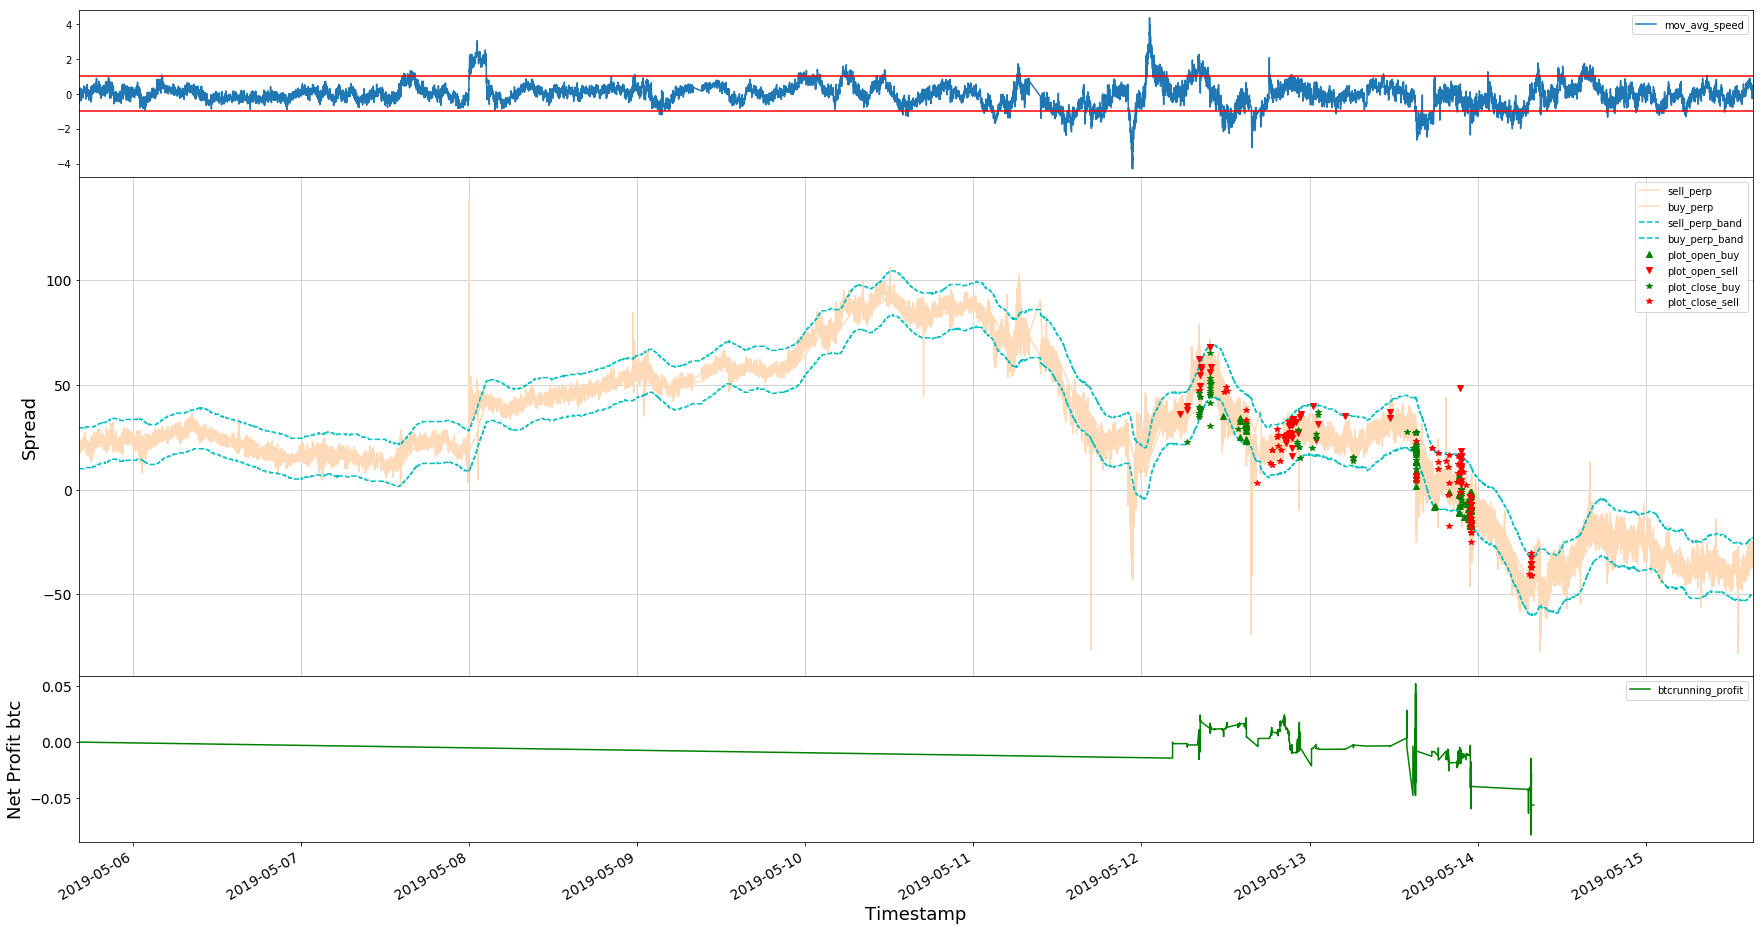

,Balance,change
day,,
2019-05-12,0.243024,NaN
2019-05-13,0.244727,0.001703
2019-05-14,0.216575,-0.028152


# new buys:                                       83
# new sells:                                      58
# close buys:                                     68
# close sells:                                    82
avg buy spread price:                           12.9
avg sell spread price:                          13.1
profit ($):                                   -474.1
profit (B):                               -0.0565462
------------                                        
live time GMT             2019-05-15 16:17:16.871739
equity                                   0.000157212
open PNL                                           0
balance                                   0.00015721
availableFunds                            0.00015721
Name: overview, dtype: object

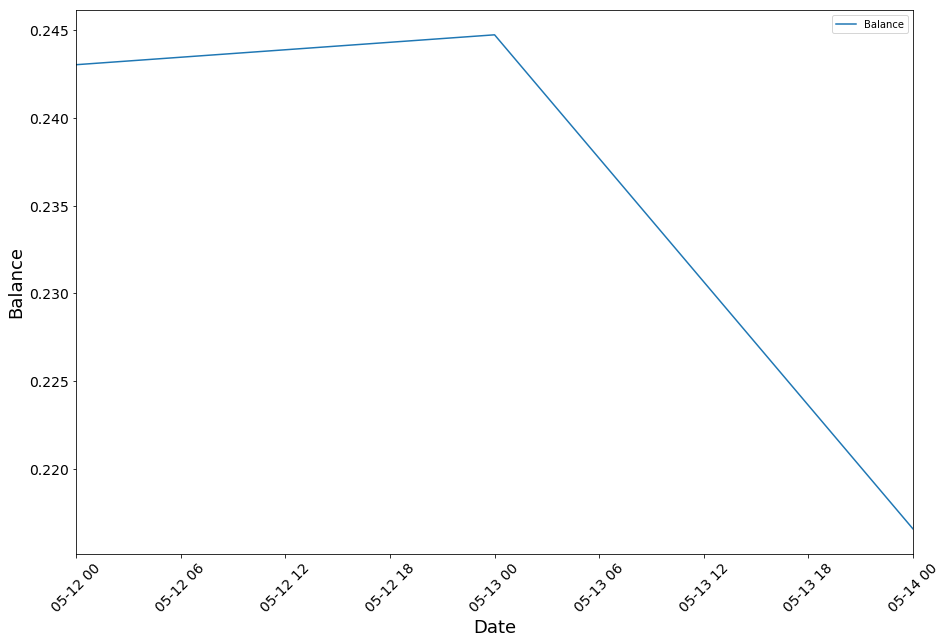

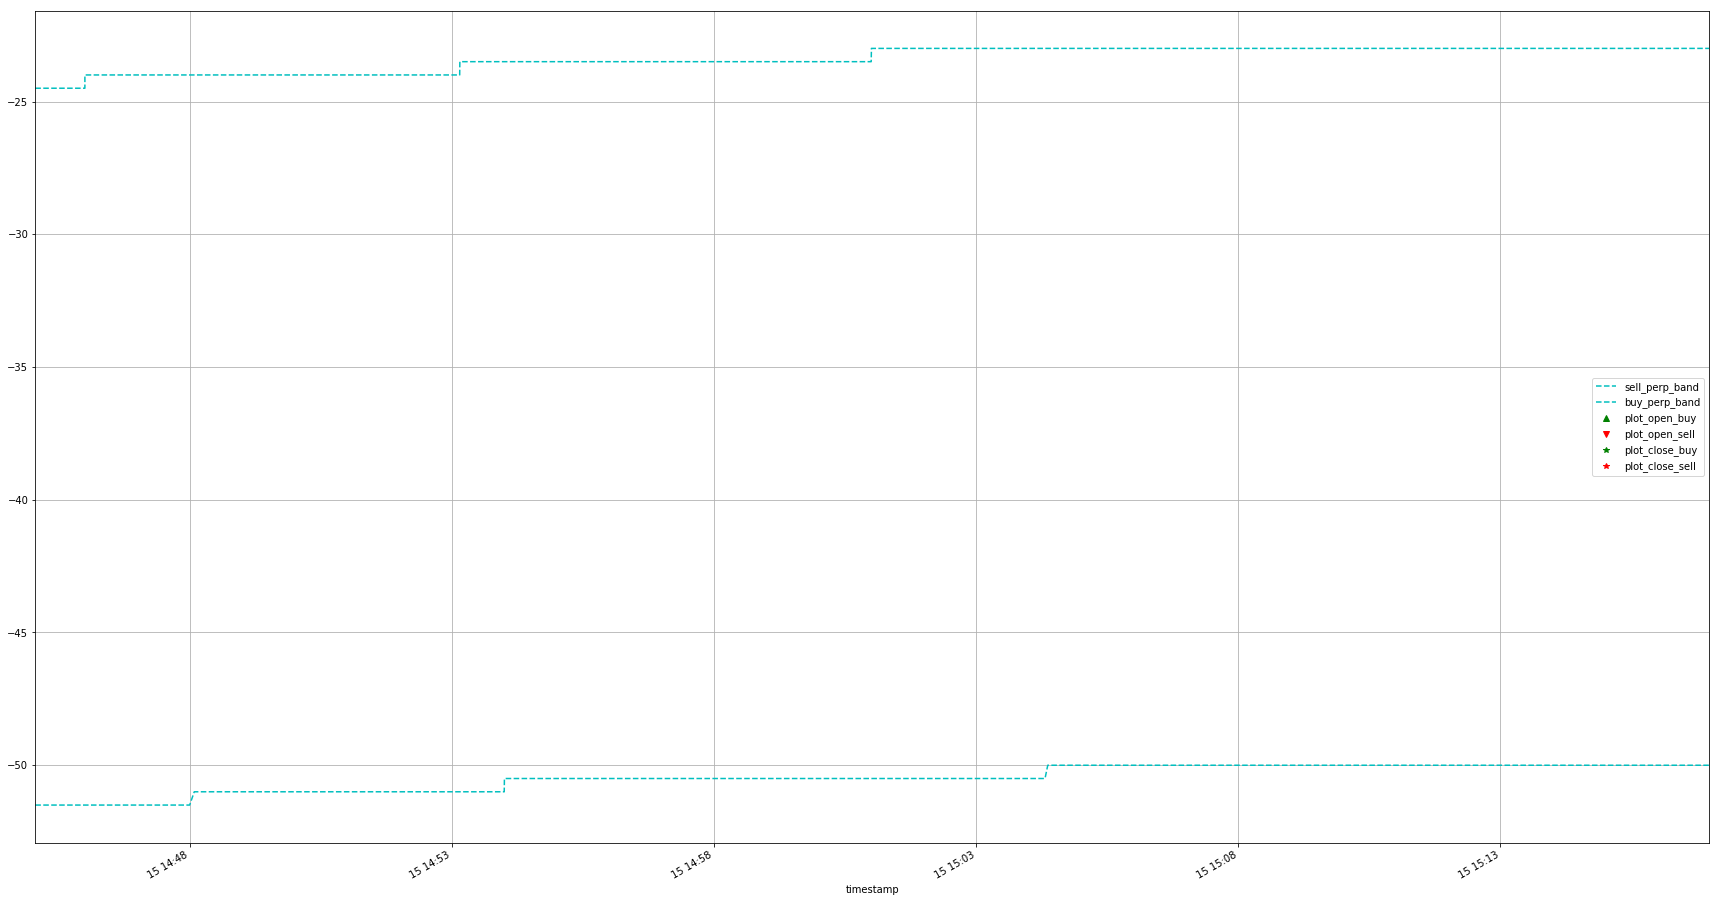

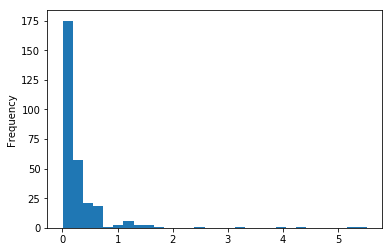

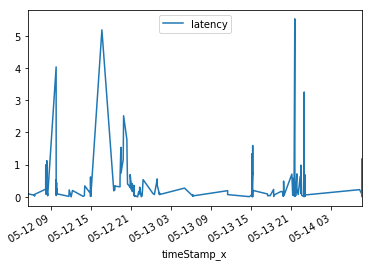

In [41]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

account_name = "spread" #"breakout", "hedge" , "fixed_levels"
  
if account_name == "breakout":
    url = "https://www.deribit.com"
    key = "5WmZQy1zCvFHs"
    secret = "X3OPUPVAVUTBGKH5XH6DZEOG4LE5R44F" 
    size = 250
    mov_avg = 150
    margin = 0.1/100
    taker = np.mean([0.05,0.075])/100
    maker = np.mean([-0.025,-0.02])/100
    fees = (taker+maker)
    manual_midpoint = [False,0,50]  # True, sell price, buy_price
 
elif account_name == "hedge":
    url = "https://www.deribit.com"
    key = "5Vs4XAnPUoNsw"
    secret = "NX6K5Z6524AH23VQZRLAYOZQIMDUOPLH"
    
elif account_name == "spread":
    url = "https://www.deribit.com"
    key = "5WmL4PVQDkYsr"
    secret = "SCUMOH5HNLQ6DBVD7LYJJQDIGHRSHWQO"
    size = 500
    mov_avg = 150
    margin = 0.13/100
    taker = np.mean([0.05,0.075])/100
    maker = np.mean([-0.025,-0.02])/100
    fees = (taker+maker)
    manual_midpoint = [False,0,50]  # True, sell price, buy_price
    
elif account_name == "fixed_levels":
    url = "https://www.deribit.com"
    key = "4mEajzAMfZCNo"
    secret = "XQHIZ2W4K4ZBAJB3XKN6SN7H2RAJNQFO"
    size = 125
    mov_avg = 80 # redundant
    margin = 0.09/100 # redundant
    taker = 0.075/100 
    maker = -0.02/100
    fees = (taker+maker)
    manual_midpoint = [True,-10,10]  # True, sell price, buy_price
else:
    raise Exception("account name doens't match list of known accounts")
    
client = RestClient(key, secret, url)

curr = "btc" #"btc"
manual = True #<<<<<<<
days = 10
data_source = "duel" #"duel"
#####
num_rows = 15000
### auto ######
if manual == False:
    now = datetime.datetime.now()
    start = datetime.datetime(now.year,now.month,now.day-days) #datetime.datetime(2018,9,21) earliest
elif manual == True:
    transaction_log_file = "transaction_log.csv"
    start = datetime.datetime.now()-datetime.timedelta(days=days) #datetime.datetime(2019,2,27) #################<<<<<<<<<<<<<<<<<<<<<<<#############

##############
#end = start + datetime.timedelta(days=days)#datetime.datetime(2018,10,14)
end = datetime.datetime.now()
if days == 1:
    file_date = str(start.date())
else:
    file_date = str(start.date())+"_to_"+str((end-datetime.timedelta(minutes=1)).date())
#####
directory = arb_algo_path+"\data\deribit performance\\"

date = datetime.datetime.utcnow()
fut_sym, back_sym = contract_sym(date)
inst = {"perp":"BTC-PERPETUAL",
        "fut":fut_sym}
############################################
##### add in downloaded site trade data that has PL of each trade ##MUST DOWNLOAD FROM SITE BEFORE and delete old one #######
if manual == False:
    fin = end.date()
    beg = fin-datetime.timedelta(days=7)
    b = str(beg.year)+str(beg.month)+str(beg.day)+"000000"
    files = os.listdir(downloads_path)
    file, = [x for x in files if "transaction_log"+b in x]
    name = file
else:
    name = transaction_log_file #"transaction_log20181012000000-20181019000010.csv"

data = pd.read_csv(downloads_path+name,skiprows=1)
data["Price"] = data["Price"].str.replace("USD","").astype(float)
data["Order Id"] = data["Order Id"].astype(str)
balance_data = data.copy() ### used for balances below
history = data.copy()
old_cols = ["Date","Instrument","Side","Price","Quantity","Fee paid","Order Id"]
want_cols = ["timeStamp","instrument","side","price","quantity","fee","orderId"]
rename_cols = dict(zip(old_cols,want_cols))
history = history.rename(rename_cols,axis="columns")
history["timeStamp"] = pd.to_datetime(history["timeStamp"]).dt.tz_localize(None)
raw_numbers = history.copy()

history = history[want_cols]
history["timeStamp"] = pd.to_datetime(history["timeStamp"])
print(start,end)
history = history[(history["timeStamp"]>=start) & (history["timeStamp"]<=end)]
history.sort_values("timeStamp",inplace=True,ascending=False)
history["weighted_price"] = history["price"]*history["quantity"]

math_cols = ["timeStamp","fee","price","weighted_price","quantity"]
other_cols = ["timeStamp",'instrument', 'side',"orderId"]

summer = history[math_cols].groupby("timeStamp").sum()

summer = summer.merge(history[other_cols],on="timeStamp",how="left")
summer.sort_values("timeStamp",inplace=True,ascending=False)
summer = summer.drop_duplicates()
summer["price"] = summer["weighted_price"]/summer["quantity"]
summer.drop("weighted_price",inplace=True,axis=1)
summer.reset_index(inplace=True,drop=True)
summer["inst_back"] = summer["instrument"].shift(-1)
summer["inst_forward"] = summer["instrument"].shift(1)
dups = (summer["instrument"] == summer["inst_back"]) | (summer["instrument"] == summer["inst_forward"])
mergings = summer[dups]
unique_perp = mergings[["orderId","fee","quantity","price"]].groupby("orderId").agg({"fee":"sum",
                                                                                     "quantity":"sum",
                                                                                     "price":"mean"})
unique_perp = unique_perp.merge(mergings[["instrument","orderId","timeStamp","side"]].drop_duplicates("orderId"),on="orderId")

summer = summer[dups == False]
summer = summer.append(unique_perp,sort=False)
summer = summer.sort_values("timeStamp",ascending=False)
summer = summer.drop(["inst_back","inst_forward"],axis=1)
summer = summer.reset_index(drop=True)
#display(summer.head(2))
#display(summer)

print(summer.shape)
results = []
question_mark = []
pairs = []
new_row = {}
ix = 1
while True:
    if ix+1 >= len(summer):
        print("finished")
        break
    time_diff = (summer.loc[ix-1,"timeStamp"] - summer.loc[ix,"timeStamp"]).total_seconds()
    quantity_diff = summer.loc[ix-1,"quantity"] == summer.loc[ix,"quantity"]
    instrument_diff = summer.loc[ix-1,"instrument"] != summer.loc[ix,"instrument"]
    side_diff = summer.loc[ix-1,"side"] != summer.loc[ix,"side"]
    if (time_diff > 0 and
        time_diff < 10 and
        quantity_diff == True and
        instrument_diff == True and
        side_diff == True):
        new_row= {}
        if summer.loc[ix-1,"instrument"] == inst["perp"]:
            p = -1
            f = 0
        else:
            p = 0
            f = -1
        ##perp
        new_row["timeStamp_x"] = summer.loc[ix+p,"timeStamp"]
        new_row["fee_x"] = summer.loc[ix+p,"fee"]
        new_row["price_x"] = summer.loc[ix+p,"price"]
        new_row["quantity_x"] = summer.loc[ix+p,"quantity"]
        new_row["instrument_x"] = summer.loc[ix+p,"instrument"]
        new_row["side_x"] = summer.loc[ix+p,"side"]
        new_row["orderId_x"] = summer.loc[ix+p,"orderId"]
        ##future
        new_row["timeStamp_y"] = summer.loc[ix+f,"timeStamp"]
        new_row["fee_y"] = summer.loc[ix+f,"fee"]
        new_row["price_y"] = summer.loc[ix+f,"price"]
        new_row["quantity_y"] = summer.loc[ix+f,"quantity"]
        new_row["instrument_y"] = summer.loc[ix+f,"instrument"]
        new_row["side_y"] = summer.loc[ix+f,"side"]
        new_row["orderId_y"] = summer.loc[ix+f,"orderId"]
        results.append(new_row)
        pairs.append(ix-1)
        pairs.append(ix)
        ix+=2
    else:
        ix+=1

## work out average buy price and sell price of all individual trades (reglasdless of pairing)
raw_numbers["timeStamp"] = pd.to_datetime(raw_numbers["timeStamp"])
raw_numbers = raw_numbers[raw_numbers["timeStamp"]>start]
raw_numbers["weighted_avg"] = raw_numbers["price"] * raw_numbers["quantity"]
perp_buy = raw_numbers[raw_numbers["side"].str.contains("buy") & (raw_numbers["instrument"]=="BTC-PERPETUAL")]
perp_buy_avg = perp_buy["weighted_avg"].sum()/perp_buy["quantity"].sum()
perp_sell = raw_numbers[raw_numbers["side"].str.contains("sell") & (raw_numbers["instrument"]=="BTC-PERPETUAL")]
perp_sell_avg = perp_sell["weighted_avg"].sum()/perp_sell["quantity"].sum()
fut_buy = raw_numbers[raw_numbers["side"].str.contains("buy") & (raw_numbers["instrument"]== inst["fut"])]
fut_buy_avg = fut_buy["weighted_avg"].sum()/fut_buy["quantity"].sum()
fut_sell = raw_numbers[raw_numbers["side"].str.contains("sell") & (raw_numbers["instrument"]==inst["fut"])]
fut_sell_avg = fut_sell["weighted_avg"].sum()/fut_sell["quantity"].sum()
print("avg perp buy price",round(perp_buy_avg,2),"avg perp sell price",round(perp_sell_avg,2),"total avg profit perp trades",round(perp_sell_avg-perp_buy_avg,2))
print("avg fut buy price",round(fut_buy_avg,2),"avg fut sell price",round(fut_sell_avg,2),"total avg profit fut trades",round(fut_sell_avg-fut_buy_avg,2))
print("avg_buy_spread:",round(perp_buy_avg-fut_sell_avg,2),"avg_sell_spread:",round(perp_sell_avg-fut_buy_avg,2))
gross_prof = round(perp_sell_avg-perp_buy_avg+fut_sell_avg-fut_buy_avg,2)
mid_avg_price = int(np.mean([perp_sell_avg,perp_buy_avg,fut_sell_avg,fut_buy_avg]))
adjusted_size = (size*10)/mid_avg_price # amount of BTC traded
print("avg gross profit per round trip($):",gross_prof,"@ 1 BTC")
fees_fut = np.mean([fut_buy_avg,fut_sell_avg])*((0.05-0.02)/100)
fees_perp = np.mean([perp_buy_avg,perp_sell_avg])*((0.075-0.025)/100)
avg_fees_RT = round(fees_fut+fees_perp,2)
print("avg fees per RT($):",avg_fees_RT,"@ 1 BTC")
settlement_funding = raw_numbers[raw_numbers["Type"]=="settlement"]
total_funding = round(-(settlement_funding["Funding"] * settlement_funding["price"]).sum(),2)
total_contracts = raw_numbers[raw_numbers["Type"]!="settlement"]["quantity"].sum()/4 #x2 for each trade in a leg, x2 for each leg in a spread
total_RT = round(total_contracts/size)
avg_funding_RT = round(total_funding/adjusted_size/total_RT,2)

try:
    print("avg funding per RT($):",avg_funding_RT,"@ 1 BTC")
    net_prof_RT = round(gross_prof - avg_fees_RT - avg_funding_RT,2)
    print("net profit per RT($):",net_prof_RT,"@ 1 BTC")
    print("total round trips:",total_RT)
    print("total days:",days-0.5)
    expected_total_profit = round(net_prof_RT*total_RT,2)
    print("expected total profit($):",expected_total_profit,"@ 1 BTC")
    print("expected total profit(B):",round(expected_total_profit/mid_avg_price,8),"@ 1 BTC")
    yearly_profit_3btc = int((expected_total_profit/(days-0.5))*3*365)
    print("forecast yearly profit($) at 3BTC:",yearly_profit_3btc)
    yearly_return_cap = round(yearly_profit_3btc/mid_avg_price/0.7,1)
    print("yearly return on capital (x's):",yearly_return_cap)
    monthly_return_per = int(yearly_return_cap/12*100)
    print("monthly % return:",monthly_return_per)
    compounded_yearly_return_dollar = int(0.7*mid_avg_price*(1+(monthly_return_per/100))**12)
    print("compounded_yearly_return:",compounded_yearly_return_dollar)
except:
    print("forcast data has some issues")

##print trades that where never paired up for some reason
not_paired = [ix for ix in summer.index if ix not in pairs][::-1]
not_paired_trades = summer.loc[not_paired,:]
print()
print("# not paired trades",len(not_paired_trades))
display(not_paired_trades)

results = pd.DataFrame(results)
results["spread_price"] = results["price_x"] - results["price_y"]
results["latency"] = (results["timeStamp_x"] - results["timeStamp_y"]).abs()
results.loc[results["side_x"] == "open buy","plot_open_buy"] = results["spread_price"]
results.loc[results["side_x"] == "open sell","plot_open_sell"] = results["spread_price"]
results.loc[results["side_x"] == "close buy","plot_close_buy"] = results["spread_price"]
results.loc[results["side_x"] == "close sell","plot_close_sell"] = results["spread_price"]
results = results.sort_values("timeStamp_x",ascending=True)
results[["orderId_x","orderId_y"]] = results[["orderId_x","orderId_y"]].astype(str)
display("combined trades",results)
 
master = deri_hist_data(start.date(),end.date(),mov_avg,margin,fees,manual_midpoint,data_source=data_source)

## merge both ###
final_master = master.merge(results,left_on="timestamp",right_on="timeStamp_x",how="outer",sort=True)
final_master[list(master.columns)] = final_master[list(master.columns)].ffill()
final_master = final_master[(final_master["timestamp"]>=start) & (final_master["timestamp"]<=end)]
display("hist data + combined trades",final_master.tail())
##########################################


data["timestamp"] = pd.to_datetime(data["Date"]).dt.tz_localize(None)
data = data.drop("Date",axis=1)
data = data[(data["timestamp"]>=start) & (data["timestamp"]<=end)]
if len(data) == 0:
    print("trade data is empty")
    data.loc[0,:] = np.nan
    data["timestamp"] = datetime.datetime.now()
#data = data.groupby("timestamp").first())
#data["timestamp"] = data.index
data = data.sort_values("timestamp",ascending=True)
data.reset_index(inplace=True,drop=True)
data["balance_diff"] = data["Balance"].diff(1)
trades = data["Type"] != "settlement"
###data["running_profit"] = data["balance_diff"].cumsum()
try:
    settled_perp_funding = data[(data["Instrument"]=="BTC-PERPETUAL") & (data["Type"] == "settlement")]["Funding"].values[0]
except:
    settled_perp_funding = 0
data["funding_avg"] = settled_perp_funding/len(trades)
data["Cash flow"] = data.loc[trades,"Cash flow"].astype(float)
data["trade_profit"] = data.loc[trades,"Cash flow"] - data.loc[trades,"Fee paid"] + data.loc[trades,"funding_avg"]
data["running_profit"] = data.loc[trades,"trade_profit"].cumsum()
data["running_profit"] = data["running_profit"].ffill()
data["usd"+"running_profit"] = data["running_profit"]*data["Price"]
data["btc"+"running_profit"] = data["running_profit"]

prof_data = data[(data["timestamp"]>=start) & (data["timestamp"]<=end)]
prof_data.loc[-1] = np.nan
prof_data.loc[-1,"timestamp"] = start
prof_data.loc[-1,"usd"+"running_profit"] = 0
prof_data.loc[-1,"btc"+"running_profit"] = 0
prof_data.loc[-1,"running_profit"] = 0
prof_data.loc[0,"usd"+"running_profit"] = 0
prof_data.loc[0,"btc"+"running_profit"] = 0
prof_data.loc[0,"running_profit"] = 0
prof_data = prof_data.sort_values("timestamp")
prof_data.reset_index(inplace=True,drop=True) 
display("profit data",prof_data.tail())

####################################################
## plot stuff ####
fig,axes = plt.subplots(nrows=3,ncols=1,figsize=(30,17),gridspec_kw = {'height_ratios':[1, 3, 1]},sharex=True)
plt.subplots_adjust(hspace=.0)

### old style of plotting
#final_master.plot(x="timestamp",y=["sell_perp_band","buy_perp_band","sell_perp","buy_perp",
#                                   "plot_open_buy","plot_open_sell","plot_close_buy","plot_close_sell"],style=["grey","grey","lightgrey","lightgrey","g^","rv","g*","r*"],ax=axes[0])

### new/accutrate style of plotting
##plot speed
print("%_beyond_mid_avg_rolling",final_master["%_beyond_mid_avg_rolling"].values[-1])
print("mov_avg_speed",final_master["mov_avg_speed"].values[-1])
#final_master.plot(x="timestamp",y="spread_mid_avg_rolling_std",grid=False,ax=axes[0]) 
#final_master.plot(x="timestamp",y="%_beyond_mid_avg_rolling",grid=False,ax=axes[0]) #mov_avg_speed
final_master.plot(x="timestamp",y="mov_avg_speed",grid=False,ax=axes[0]) 
axes[0].axhline(1,color="r")
axes[0].axhline(-1,color="r")
##plot spread
sell_spread = final_master[final_master["sell_perp"] > final_master["spread_mid_avg_rolling"]]
buy_spread = final_master[final_master["buy_perp"] < final_master["spread_mid_avg_rolling"]]   
sell_spread.plot("timestamp",["sell_perp"],style=['peachpuff'],grid=True,ax=axes[1])
buy_spread.plot("timestamp",["buy_perp"],style=['peachpuff'],grid=True,ax=axes[1])
ax = final_master.plot("timestamp",["sell_perp_band","buy_perp_band","plot_open_buy","plot_open_sell","plot_close_buy","plot_close_sell"],style=["c--","c--","g^","rv","g*","r*"],ax=axes[1],grid=True)
ax.grid(color='lightgrey',linewidth=1)

#ax.tick_params(axis="x","Spread",fontsize=18)
axes[1].tick_params(axis="both",labelsize=14)
axes[1].set_ylabel("Spread",fontsize=18)
ax1_lim = axes[1].get_xlim()

prof_data.plot(x="timestamp",y=[curr+"running_profit"],style=["g","w"],ax=axes[2]) 
axes[2].tick_params(axis="both",labelsize=14)
axes[2].set_ylabel("Net Profit "+curr,fontsize=18)
axes[2].set_xlabel("Timestamp",fontsize=18)
plt.savefig(directory+file_date+"_"+account_name+".jpg")
axes[2].set_xlim(ax1_lim)
plt.show()


combined_trades = results[(results["timeStamp_x"]>=start) & (results["timeStamp_x"]<=end)].reset_index(drop=True)
detailed_trades = summer[(summer["timeStamp"]>=start) & (summer["timeStamp"]<=end)].reset_index(drop=True)

## other details
new_buys = combined_trades["plot_open_buy"].count()
new_sells = combined_trades["plot_open_sell"].count()
close_buys = combined_trades["plot_close_buy"].count()
close_sells = combined_trades["plot_close_sell"].count()
avg_buy = round(combined_trades[["plot_open_buy","plot_close_buy"]].mean(axis=1).mean(axis=0),1)
avg_sell = round(combined_trades[["plot_open_sell","plot_close_sell"]].mean(axis=1).mean(axis=0),1)

info = client.account()

account = {}
account["# new buys:"] = new_buys
account["# new sells:"] = new_sells
account["# close buys:"] = close_buys
account["# close sells:"] = close_sells
account["avg buy spread price:"] = avg_buy
account["avg sell spread price:"] = avg_sell
account["profit ($):"] = prof_data.iloc[-1]["usd"+"running_profit"].round(2)
account["profit (B):"] = prof_data.iloc[-1]["btc"+"running_profit"].round(8)
account["------------"] = ""
if datetime.datetime.now().date() <= end.date():
    account["live time GMT"] = datetime.datetime.now()
    account["equity"] = info["equity"]
    account["open PNL"] = info["PNL"]
    account["balance"] = info["balance"]
    account["availableFunds"] = info["availableFunds"]
else:
    account["equity,PNL,balance"] = "unavailable right now"
account = pd.Series(account,name="overview")
#######

### balance history
balance_data["Date"] = pd.to_datetime(balance_data["Date"]).dt.tz_localize(None)
balance_data = balance_data[(balance_data["Date"]<=end+datetime.timedelta(days=1))]
balance_data["day"] = balance_data["Date"].dt.date
balance_data = balance_data.groupby("day").first()
balance_data = balance_data[["Balance"]]
balance_data["change"] = balance_data.diff(1)
display(balance_data)
##balance plot ##
balance_data.plot(y="Balance",figsize=(15,10),rot=45)
plt.xlabel("Date",fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("Balance",fontsize=18)
plt.yticks(fontsize=14)
plt.savefig(directory+file_date+"_balance"+"_"+account_name+".jpg")

writer = pd.ExcelWriter(directory+file_date+"_"+account_name+".xlsx")
combined_trades.to_excel(writer,sheet_name ="combined_trades")
detailed_trades.to_excel(writer,sheet_name ="detailed_trades")
account.to_excel(writer,sheet_name ="overview & account info")
balance_data.to_excel(writer,sheet_name = "historical balances")
writer.save()

display(account)

#zoome in trades
fig,axes2 = plt.subplots(nrows=1,ncols=1,figsize=(30,17))
final_master[-3000:].plot("timestamp",["sell_perp_band","buy_perp_band","plot_open_buy","plot_open_sell","plot_close_buy","plot_close_sell"],style=["c--","c--","g^","rv","g*","r*"],ax=axes2,grid=True)
plt.show()

## latency
results["latency"] = results["latency"].dt.total_seconds()
results["latency"].plot.hist(bins=30)
plt.show()
results.plot(y="latency",x="timeStamp_x")